Runnning with gammapy-dev/IRF_model
-----------------------------------

Fitting asimov datasets with nuisance parameters based on the different
livetimes



In [1]:
######################################################################
# Setup
# ~~~~~
# 

import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 

from  Dataset_Setup import Setup, GaussianCovariance_matrix

In [2]:
######################################################################
# Read dataset
# ------------
# 

c = Dataset_load.load_config()
awo, aw, ewo, ew = c['_colors']  

livetimes = c['livetimes']
zero = c['zero'] 
norm = c['norm'] 
tilt = c['tilt'] 
bias = c['bias'] 
resolution = c['resolution'] 
magnitude = c['magnitude'] 
corrlength = c['corrlength']
sys = c['sys'] 
folder = c['folder']
nbidx = 0

livetimes = livetimes


from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)

In [17]:
%%time
datasets_input = []
for l in [c['livetime']]:
    datasets_i  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                                   livetime = f"{l}-hr",
                                            parameters = None)
    datasets_input.append(datasets_i)

loaded dataset:
/home/katrin/Documents/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-2.154434690031884-hr.fits.gz
CPU times: user 5.41 s, sys: 350 ms, total: 5.76 s
Wall time: 5.78 s


In [4]:
######################################################################
# Datasets
# --------
# 

def set_up(dataset_input):
    
    setup = Setup(dataset_input=dataset_input)
    #setup.set_up_irf_sys(bias, resolution, norm, tilt)
    dataset_asimov, dataset_asimov_N = setup.run()
    # irf model
    setup.set_irf_model(dataset_asimov_N)
    if sys == "Eff_area":
        dataset_asimov_N.models.parameters['resolution'].frozen = True
        dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
        dataset_asimov_N.irf_model.parameters['bias'].frozen = True
        setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
        e_reco_n = 10
        
        
    if sys == "E_reco":
        dataset_asimov_N.models.parameters['resolution'].frozen = True
        dataset_asimov_N.irf_model.parameters['tilt'].frozen = True
        dataset_asimov_N.irf_model.parameters['bias'].frozen = False
        dataset_asimov_N.irf_model.parameters['norm'].frozen = True
        setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
        e_reco_n = 2000
        
        
    if  "Combined" in sys:
        dataset_asimov_N.models.parameters['resolution'].frozen = True
        dataset_asimov_N.irf_model.parameters['bias'].frozen = False
        dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
        dataset_asimov_N.irf_model.parameters['bias'].frozen = False
        setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
        e_reco_n = 2000

    # piece wise model
    # remove old bkg model
    #setup.unset_model(dataset_asimov_N, FoVBackgroundModel)
    #setup.set_piecewise_bkg_model(dataset_asimov_N)
    # energy of the following parameters smaller than ethrshold
    #dataset_asimov_N.background_model.parameters['norm0'].frozen = True
    #dataset_asimov_N.background_model.parameters['norm1'].frozen = True
    #dataset_asimov_N.background_model.parameters['norm2'].frozen = True
    #dataset_asimov_N.background_model.parameters['norm3'].frozen = True
    #setup.set_bkg_prior(dataset_asimov_N, magnitude, corrlength)

    
       
    return dataset_asimov_N, dataset_asimov

In [5]:
# datasets_N = []
# datasets = []

# for d in datasets_input:
#     dataset_asimov_N, dataset_asimov = set_up(d)
#     #dataset_asimov_N.e_reco_n = 10 # to save memory  e_reco_n
    
#     datasets_N.append(dataset_asimov_N)
#     datasets.append(dataset_asimov)

# print(datasets[0].models)

In [8]:
%%time
models , models_N= [], []
for i, d in enumerate(livetimes):

    print(i)
    path = f'../{folder}/data/0_model_livetime_{livetimes[i]}.yml'
    models.append(Models.read(path))


e_reco_n = 1000

if "Eff_area" in sys:
    e_reco_n = 30

for i, d in enumerate(livetimes):
    path = f'../{folder}/data/0_model_nui_livetime_{livetimes[i]}_{e_reco_n}.yml'
    models_N.append( Models.read(path))
            
        

#39min 32

0
1
2
3
4
5
6
7
8
9
10
11
12
CPU times: user 753 ms, sys: 3.07 ms, total: 756 ms
Wall time: 764 ms


In [9]:
labels = [str(int(l)) for l in livetimes]
models_list = models_N
pars =   [('bias', 'resolution'), ('norm', 'tilt')]

colors_default =  plt.rcParams['axes.prop_cycle'].by_key()['color'] 
colors_default = colors_default* 5

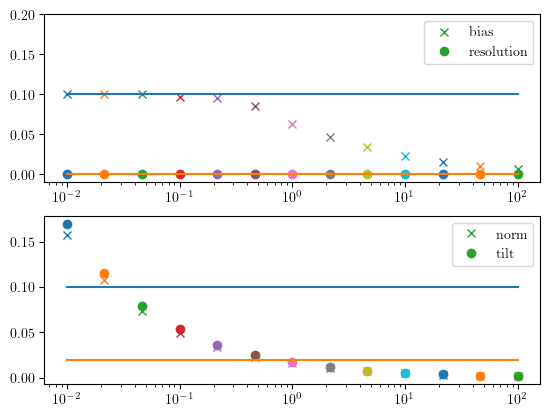

In [10]:
i = 0
fig,axs = plt.subplots(2,1)
for l, m in zip(livetimes, models_list):
    axs[0].plot(l, m.parameters[pars[0][0]].error, 'x', label = "bias", color = colors_default[i])
    axs[0].plot(l, m.parameters[pars[0][1]].error, 'o' , label = "resolution", color = colors_default[i])
    axs[1].plot(l, m.parameters[pars[1][0]].error, 'x' , label = "norm", color = colors_default[i])
    axs[1].plot(l, m.parameters[pars[1][1]].error, 'o' , label = "tilt", color = colors_default[i])
    i +=1
    
    
axs[0].plot([livetimes[0],livetimes[-1]], [bias, bias])
axs[0].plot([livetimes[0],livetimes[-1]], [resolution, resolution])
axs[1].plot([livetimes[0],livetimes[-1]], [norm, norm])
axs[1].plot([livetimes[0],livetimes[-1]], [tilt, tilt])  

for a in axs:
    a.set_xscale("log")
    a.legend()


    from collections import OrderedDict

    handles, labels = a.get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    a.legend(by_label.values(), by_label.keys())
    
axs[0].set_ylim(-0.01, 0.2)
fig.savefig(f'../{folder}/plots/{nbidx}_irf_fit_results.pdf')

In [11]:
compute = 0
if compute:
    stat_0 = []
    for d in datasets:
        s = d.stat_sum()
        with d.models.parameters.restore_status():
            d.models.parameters['amplitude'].value = 0 
            d.models[0].parameters.freeze_all()
            bkg = FoVBackgroundModel(dataset_name=d.name)
            d.models= Models([bkg])
            fit = Fit()
            result= fit.optimize(d)
            print(result)
            stat_0.append(np.sqrt( d.stat_sum() - s))
        print(stat_0)
    np.savetxt( f'../{folder}/data/0_sqrtts.txt',  np.array(stat_0))
else:
    stat_0 = np.loadtxt( f'../{folder}/data/0_sqrtts.txt')
stat_0

FileNotFoundError: ../Combined100_PKSflare_crab_cutoff/data/0_sqrtts.txt not found.

In [12]:
from scipy.optimize import curve_fit
if len(stat_0)>1:
    # Given data
    x_values =livetimes
    y_values =stat_0

    # Define the linear function
    def linear_fit(x, a, b):
        return a * x**b

    # Perform the curve fit
    params, covariance = curve_fit(linear_fit, x_values, y_values)
    a_fit, b_fit = params

    # Create a log-log plot
    plt.figure(figsize=(8, 6))
    plt.loglog(x_values, y_values, 'bo', label='Data Points')
    plt.loglog(x_values, linear_fit(x_values, a_fit, b_fit), 'r--', label=f'Linear Fit: y = {a_fit:.2f} {b_fit:.2f}')
    plt.xlabel('Livetime [hr]')
    plt.ylabel('Sqrt(TS)')
    plt.legend()
    plt.show()


    def compute_x_for_given_y(y_value, a, b):
        """
        Computes the x value for a given y value using the linear fit equation.

        Args:
            y_value (float): The desired y value.
            a (float): Coefficient 'a' from the linear fit equation.
            b (float): Coefficient 'b' from the linear fit equation.

        Returns:
            float: The corresponding x value.
        """
        # Solve for x using the inverse of the linear fit equation
        x_value = (y_value / a) ** (1 / b)
        return x_value

    # Example usage
    desired_y = 5  # Replace with your desired y value
    computed_5 = compute_x_for_given_y(desired_y, a_fit, b_fit)
    print(f"For a desired sig of {desired_y:.2f}, the corresponding livetime is approximately {computed_5:.6f}.")
    desired_y = 50  # Replace with your desired y value
    computed_50 = compute_x_for_given_y(desired_y, a_fit, b_fit)
    print(f"For a desired sig of {desired_y:.2f}, the corresponding livetime is approximately {computed_50:.6f}.")


NameError: name 'stat_0' is not defined

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1183: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1184: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


AttributeError: 'numpy.ndarray' object has no attribute 'npred_signal'

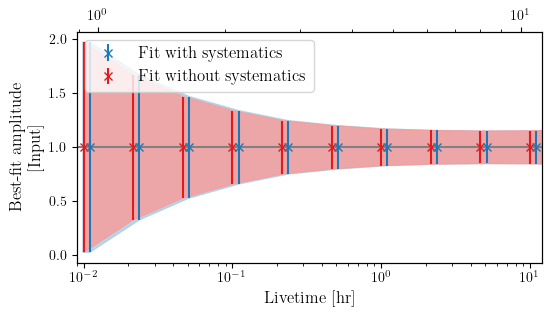

In [21]:
fontsize = 12

inputvalues = {}
for p in datasets_input[0].models[0].parameters:
    inputvalues[p.name]  = p.value

def plotting(parname = "amplitude", delta = 1):
    fig = plt.figure(figsize  = (6,3))
    inputvalue = inputvalues[parname]
    
    errs = []
    errs_N = []
    livetimes_ext = np.array(livetimes).copy(); livetimes_ext2 = np.array(livetimes).copy(); 
    livetimes_ext[-1] *=1.1;
    livetimes_ext2[0:,] *=1.1; 
    livetimes_ext2 = np.insert(livetimes_ext2, 0, values =  livetimes_ext2[0]* 0.9)


    for i, d in enumerate(models_N):
        par = d.parameters[parname]
        val, err = par.value, par.error
        errs.append( err/ inputvalue )
        plt.errorbar(livetimes[i], val/ inputvalue, yerr =  err/ inputvalue,  fmt='x', 
                     color = awo[0])

        par = d.parameters[parname]
        val, err = par.value, par.error
        errs_N.append( err/ inputvalue)
        plt.errorbar( 1.1* livetimes[i] , val/ inputvalue, yerr = err/ inputvalue,  fmt='x', 
                     color = aw[0])

    

    errs_N = np.insert(errs_N, 0, values =  errs_N[0])
    plt.fill_between(  livetimes_ext2, 1- np.array(errs_N), 1+np.array(errs_N) 
                     ,color = aw[1], alpha = 0.8, label = '')
    plt.fill_between( livetimes_ext, 1- np.array(errs), 1+np.array(errs)
                     ,color = awo[1], alpha = 0.8, label = '')

    plt.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = aw[0],
                 label = 'Fit with systematics')
    plt.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = awo[0], 
                 label = 'Fit without systematics')
    plt.xlim(0.009 , 12)
    
    ax1 = plt.gca()
    xlim = ax1.get_xlim()
    plt.hlines(1, xlim[0], xlim[1], color = 'grey')
    #plt.title("Best Fit Amplitude")
    legend = plt.legend(fontsize = fontsize, loc = 'upper left' )
    plt.xscale('log')
    plt.xlabel("Livetime [hr]", fontsize = fontsize)
    plt.ylabel(f"Best-fit {parname} \n[Input]", fontsize = fontsize)

    ax2 = ax1.twiny()
    ax2.set_xscale("log")
    livetimes_shown1 = np.array(livetimes)>xlim[0] 
    livetimes_shown2= np.array(livetimes)<xlim[1]
    
    npred = [d.npred_signal().data.sum() for d in np.array(models)[livetimes_shown1 *  livetimes_shown2]]
    
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(np.array(livetimes)[[livetimes_shown1 *  livetimes_shown2]])
    clabels = [ f'{int(c)}' for c in npred]
    ax2.set_xticklabels(clabels)
    ax2.set_xlabel(r"Signal Counts", fontsize = fontsize)
    plt.tight_layout()
    ax = plt.gca()
    ax.set_ylim(1- delta, 1. + delta)
    sigma_color = 'black'
    ax.vlines(computed_50, ax.get_ylim()[0], ax.get_ylim()[1], color = sigma_color,linestyle =  'dashed')
    ax.vlines(computed_5, ax.get_ylim()[0], ax.get_ylim()[1], color = sigma_color,linestyle =  'dotted')
    ax.text(computed_50*1.05, ax.get_ylim()[1]*0.5 ,"50 $\sigma$", color = sigma_color, fontsize = fontsize)
    ax.text(computed_5*1.05, ax.get_ylim()[1]*0.5 ,"5 $\sigma$", color = sigma_color, fontsize = fontsize)
    legend.get_frame().set_alpha(0.8)
    return fig


fig = plotting(parname = "amplitude", delta = 0.4)
fig.savefig(f'../{folder}/plots/{nbidx}_best_fit_vs_livetime_amplitude.svg')
fig.savefig(f'../{folder}/plots/{nbidx}_best_fit_vs_livetime_amplitude.pdf')
fig.savefig(f'../{folder}/plots/{nbidx}_best_fit_vs_livetime_amplitude.png')

In [14]:
fig = plotting(parname = "index", delta = 0.2)
fig.savefig(f'../{folder}/plots/{nbidx}_best_fit_vs_livetime_index.svg')
fig.savefig(f'../{folder}/plots/{nbidx}_best_fit_vs_livetime_index.pdf')
fig.savefig(f'../{folder}/plots/{nbidx}_best_fit_vs_livetime_index.png')

NameError: name 'plotting' is not defined

In [ ]:
try:
    parname = "lambda_"
    fig = plotting(parname = parname, delta = 0.5)


    fig.savefig(f'../{folder}/plots/{nbidx}_best_fit_vs_livetime_{parname}.svg')
    fig.savefig(f'../{folder}/plots/{nbidx}_best_fit_vs_livetime_{parname}.pdf')
    fig.savefig(f'../{folder}/plots/{nbidx}_best_fit_vs_livetime_{parname}.png')
except:
    print("no cutoff")

In [ ]:
try:
    parname = "sigma"
    fig = plotting(parname = parname, delta = 3)


    fig.savefig(f'../{folder}/plots/{nbidx}_best_fit_vs_livetime_{parname}.svg')
    fig.savefig(f'../{folder}/plots/{nbidx}_best_fit_vs_livetime_{parname}.pdf')
    fig.savefig(f'../{folder}/plots/{nbidx}_best_fit_vs_livetime_{parname}.png')
except:
    print("no sigma")

In [ ]:
######################################################################
# RND Fluxpoints
# --------------
# 

for i, d in enumerate(datasets):
    l = livetimes[i]
    print()
    print(l)
    dataset = datasets[i]
    dataset_N = datasets_N[i]
    parameters = dataset.models[0].parameters.names
    for p in parameters:
        
        par = dataset.models[0].parameters[p]
        per = par.error /par.value * 100 
        print(f"{p}:")
        print(f"without {per:.4} %")
        par = dataset_N.models[0].parameters[p]
        per = par.error /par.value * 100 
        
        print(f"with    {per:.4} %")        

def plot_spectra():
    fig,axs = plt.subplots(len(datasets), 1, figsize = (6, 5 * len(datasets)))
    axs= axs.flatten()
    energy_power = 2
    for i, d in enumerate(datasets):
        ax = axs[i]
        live = livetimes[i]
        dataset = datasets[i]
        dataset_N = datasets_N[i]

        dataset_N.models[0].spectral_model.plot((0.1, 100) *u.TeV, energy_power = energy_power,
                                                     color = aw[0], ax = ax)    
        par = dataset_N.models[0].parameters['amplitude']
        per = par.error /par.value
        dataset_N.models[0].spectral_model.plot_error((0.1, 100) *u.TeV,energy_power = energy_power, ax = ax, 
                                                   facecolor= aw[1], alpha = 0.8, 
                                                     label = f'With nui par.\n amplitude error =  {per*100:.3}% ')
        dataset.models[0].spectral_model.plot((0.1, 100) *u.TeV,energy_power = energy_power, ax = ax, 
                                                   color= awo[0], linestyle = 'dashed')
        par = dataset.models[0].parameters['amplitude']
        per = par.error /par.value
        dataset.models[0].spectral_model.plot_error((0.1, 100) *u.TeV,energy_power = energy_power, ax = ax, 
                                                   facecolor= awo[1], alpha = 0.8,
                                                   label = f'W/o nui par.\n amplitude error =  {per*100:.3}%')
        ax.set_title(f"Livetime: {float(live):.2} hr")
        ax.set_ylim(1e-12, 1e-10)

        if i <2:
            ax.set_ylim(6e-13, 6e-9)
            
        
        #if live in lives:
        #    idx = np.where(live == lives)[0][-1]
        #    fpd_Ns[idx].data.plot(ax = ax, energy_power = energy_power, color = purple[0],
        ##                         label = "Example fluxpoint with nui par.")
        #    fpd_s[idx].data.plot(ax = ax, energy_power = energy_power, color = orange[0],
        #                        label = "Example fluxpoint w/o nui par.")
        ax.legend()
    plt.tight_layout()
    return fig
   

In [ ]:
     
fig = plot_spectra()
fig.savefig(f'../{folder}/plots/{nbidx}_spectra_with_rnd_fp.pdf')

par_names = ['index', 'amplitude', 'lambda_', 'bias', 'resolution', 'norm' , 
            'tilt']
names =  ['index', 'amplitude',  
        'bkg norm', 'bkg tilt',
          'bias', 'resolution',
          'eff. area norm' , 
            'eff. area tilt']
for i in range(len(livetimes)):

    #datasets_N[i].models.read_covariance("data", f"8_model_nui_livetime_{livetimes[i]}_covariance.dat", format="ascii.fixed_width")
    parameters = Parameters([_ for _ in datasets_N[i].models.parameters if _.name in par_names])
    cov_par = datasets_N[i].models.covariance.get_subcovariance(parameters)
    ax = cov_par.plot_correlation()
    ax.set_title(str(livetimes[i]) + " hr")
    fig = plt.gcf()
    fig.savefig(f'../{folder}/plots/{nbidx}_covmatrix_livetime_{livetimes[i]}.svg')
    fig.savefig(f'../{folder}/plots/{nbidx}_covmatrix_livetime_{livetimes[i]}.pdf')
    

In [ ]:
datasets_N[0].models.covariance.plot_correlation()